This notebook plots the size histogram of PSD-95 blobs associated with synapses.  The plots from this notebook are in Figure 6 (Postsynaptic marker size distributions) and the associated supplemental figure. 

In [1]:
import os 
import copy
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from skimage import measure
from scipy import stats
import fxsdata
from fxsdata import fxs_mouse
from at_synapse_detection import dataAccess as da
from at_synapse_detection import SynapseDetection as syn

%matplotlib notebook
#%matplotlib inline



In [2]:
allmice = np.load('psd_zlist.npy')
allmice = allmice.item()

In [3]:
volume_dict_unordered = np.load('volume_dict.npy')
volume_dict_unordered = volume_dict_unordered.item()

# Reorder Layer Data

In [4]:
mice_dict = {} 

order_dict = {'1ss':'forward', '2ss':'backward', '3ss':'backward', 
            '4ss':'backward', '5ss':'backward', '6ss':'forward',
            '7ss':'forward', '22ss':'backward'}
layer_list = ['F000', 'F001', 'F002', 'F003']

for mouse_key in allmice.keys(): 
    mice_dict[mouse_key] = {} 
    
    if order_dict[mouse_key] == 'forward': 
        print(mouse_key, 'forward')
        mice_dict[mouse_key]['Layer1'] = allmice[mouse_key]['F000']
        mice_dict[mouse_key]['Layer2'] = allmice[mouse_key]['F001']
        mice_dict[mouse_key]['Layer3'] = allmice[mouse_key]['F002']
        mice_dict[mouse_key]['Layer4'] = allmice[mouse_key]['F003']
    
    elif order_dict[mouse_key] == 'backward': 
        print(mouse_key, 'backward')
        mice_dict[mouse_key]['Layer1'] = allmice[mouse_key]['F003']
        mice_dict[mouse_key]['Layer2'] = allmice[mouse_key]['F002']
        mice_dict[mouse_key]['Layer3'] = allmice[mouse_key]['F001']
        mice_dict[mouse_key]['Layer4'] = allmice[mouse_key]['F000']
    


4ss backward
6ss forward
22ss backward
5ss backward
2ss backward
3ss backward
7ss forward
1ss forward


In [5]:
volume_dict = {} 

order_dict = {'1ss':'forward', '2ss':'backward', '3ss':'backward', 
            '4ss':'backward', '5ss':'backward', '6ss':'forward',
            '7ss':'forward', '22ss':'backward'}
layer_list = ['F000', 'F001', 'F002', 'F003']

for mouse_key in allmice.keys(): 
    volume_dict[mouse_key] = {} 
    
    if order_dict[mouse_key] == 'forward': 
        print(mouse_key, 'forward')
        volume_dict[mouse_key]['Layer1'] = volume_dict_unordered[mouse_key]['F000']
        volume_dict[mouse_key]['Layer2'] = volume_dict_unordered[mouse_key]['F001']
        volume_dict[mouse_key]['Layer3'] = volume_dict_unordered[mouse_key]['F002']
        volume_dict[mouse_key]['Layer4'] = volume_dict_unordered[mouse_key]['F003']
    
    elif order_dict[mouse_key] == 'backward': 
        print(mouse_key, 'backward')
        volume_dict[mouse_key]['Layer1'] = volume_dict_unordered[mouse_key]['F003']
        volume_dict[mouse_key]['Layer2'] = volume_dict_unordered[mouse_key]['F002']
        volume_dict[mouse_key]['Layer3'] = volume_dict_unordered[mouse_key]['F001']
        volume_dict[mouse_key]['Layer4'] = volume_dict_unordered[mouse_key]['F000']
    


4ss backward
6ss forward
22ss backward
5ss backward
2ss backward
3ss backward
7ss forward
1ss forward


# Normalize Data 

In [6]:
# Plot 10 bin histogram of psd blobs, all layers averaged, wt vs ko 

In [7]:
def bin_data(data, n_bins):
    binned_data = [] 
    data = np.array(data)
    for n in range(0, n_bins): 
        x = np.sum(data==n)    

        binned_data.append(x)
    return binned_data

In [8]:
def get_binned_data(mice_dict, volume_dict, mouse_key, layer_key, q_key): 
    """
    """
    data = mice_dict[mouse_key][layer_key][q_key]
    n_bins = 11
    binned_data = bin_data(data, n_bins)
    volume_um3 = volume_dict[mouse_key][layer_key]
    binned_data = np.array(binned_data)/volume_um3
    
    return binned_data
    
    

In [9]:
def get_histogram_data(mice_dict, volume_dict, layer, q_key): 
    """
    """
    wt_mouse_names = ['2ss', '4ss', '5ss', '22ss']
    ko_mouse_names = ['3ss', '6ss', '6ss', '1ss' ]
    wt_layerdata = np.zeros((1, 11)) #is there a better way to do this? 
    ko_layerdata = np.zeros((1, 11)) #is there a better way to do this? 
    
    wt_data = [] 
    ko_data = [] 
    
    if layer == 'Layer1': 
        layer_key = 'Layer1'
        for mouse_key in wt_mouse_names: 
            normdata = get_binned_data(mice_dict, volume_dict, mouse_key, layer_key, q_key)
            wt_data.append(normdata)
            wt_layerdata = wt_layerdata + normdata
        wt_layerdata = wt_layerdata/4
    
        for mouse_key in ko_mouse_names: 
            normdata = get_binned_data(mice_dict, volume_dict, mouse_key, layer_key, q_key)
            ko_data.append(normdata)
            ko_layerdata = ko_layerdata + normdata
        ko_layerdata = ko_layerdata/4
    
    elif layer == 'Layer4':
        layer_key = 'Layer4'
        for mouse_key in wt_mouse_names: 
            normdata = get_binned_data(mice_dict, volume_dict, mouse_key, layer_key, q_key)
            wt_data.append(normdata)
            wt_layerdata = wt_layerdata + normdata
        wt_layerdata = wt_layerdata/4
    
        for mouse_key in ko_mouse_names: 
            normdata = get_binned_data(mice_dict, volume_dict, mouse_key, layer_key, q_key)
            ko_data.append(normdata)
            ko_layerdata = ko_layerdata + normdata
        ko_layerdata = ko_layerdata/4
    
    elif layer == 'Layer23':
        for mouse_key in wt_mouse_names: 
            normdata_L2 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer2', q_key)
            normdata_L3 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer3', q_key)
            normdata_L23 = (normdata_L2 + normdata_L3)/2
            wt_data.append(normdata_L23)
            wt_layerdata = wt_layerdata + normdata_L23
        wt_layerdata = wt_layerdata/4
    
        for mouse_key in ko_mouse_names: 
            normdata_L2 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer2', q_key)
            normdata_L3 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer3', q_key)
            normdata_L23 = (normdata_L2 + normdata_L3)/2
            ko_data.append(normdata_L23)
            ko_layerdata = ko_layerdata + normdata_L23
        ko_layerdata = ko_layerdata/4
        
    elif layer == 'average': 
        for mouse_key in wt_mouse_names: 
            normdata_L1 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer1', q_key)
            normdata_L2 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer2', q_key)
            normdata_L3 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer3', q_key)
            normdata_L4 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer4', q_key)
            normdata_L23 = (normdata_L2 + normdata_L3)/2
            normdata_avg = (normdata_L1 + normdata_L23 + normdata_L4)/3
            wt_data.append(normdata_avg)
            wt_layerdata = wt_layerdata + normdata_avg
            
        wt_layerdata = wt_layerdata/4
    
        for mouse_key in ko_mouse_names: 
            normdata_L1 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer1', q_key)
            normdata_L2 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer2', q_key)
            normdata_L3 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer3', q_key)
            normdata_L4 = get_binned_data(mice_dict, volume_dict, mouse_key, 'Layer4', q_key)
            normdata_L23 = (normdata_L2 + normdata_L3)/2
            normdata_avg = (normdata_L1 + normdata_L23 + normdata_L4)/3
            ko_data.append(normdata_avg)
            ko_layerdata = ko_layerdata + normdata_avg
        ko_layerdata = ko_layerdata/4
    
    
    # perform 10 two sample t tests
    pval_list = [] 
    wt_data = np.array(wt_data)
    ko_data = np.array(ko_data)
    for z in range(1, 11):
        pval = scipy.stats.ttest_ind(wt_data[:, z], ko_data[:, z])
        pval = pval.pvalue
        pval_list.append(pval)
    pval_list = np.array(pval_list)
    wt_layerdata = wt_layerdata.flatten()
    ko_layerdata = ko_layerdata.flatten()
    
    return [wt_data, ko_data, pval_list]
            

In [10]:
layer_list = ['average', 'Layer1', 'Layer23', 'Layer4']
layer_title_list = ['All Layers', 'Layer 1', 'Layer 2/3', 'Layer 4']
layer_fn_list = ['all', 'L1', 'L23', 'L4']
synapse_labels = ['Glut.', 'Glut. VGluT1','Glut. VGluT2', 'Glut. VGluT1/VGluT2']


<IPython.core.display.Javascript object>


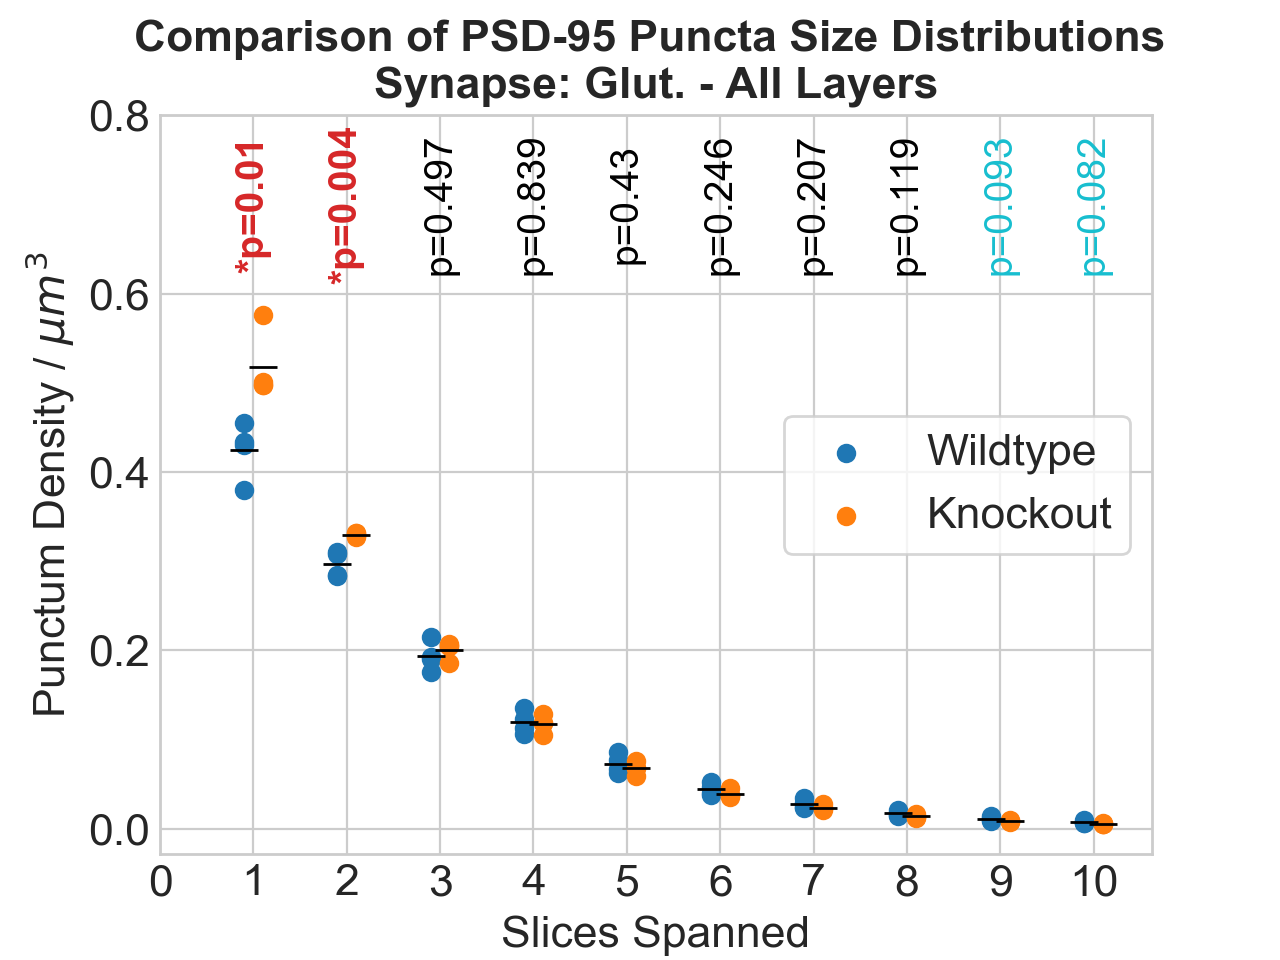

<IPython.core.display.Javascript object>


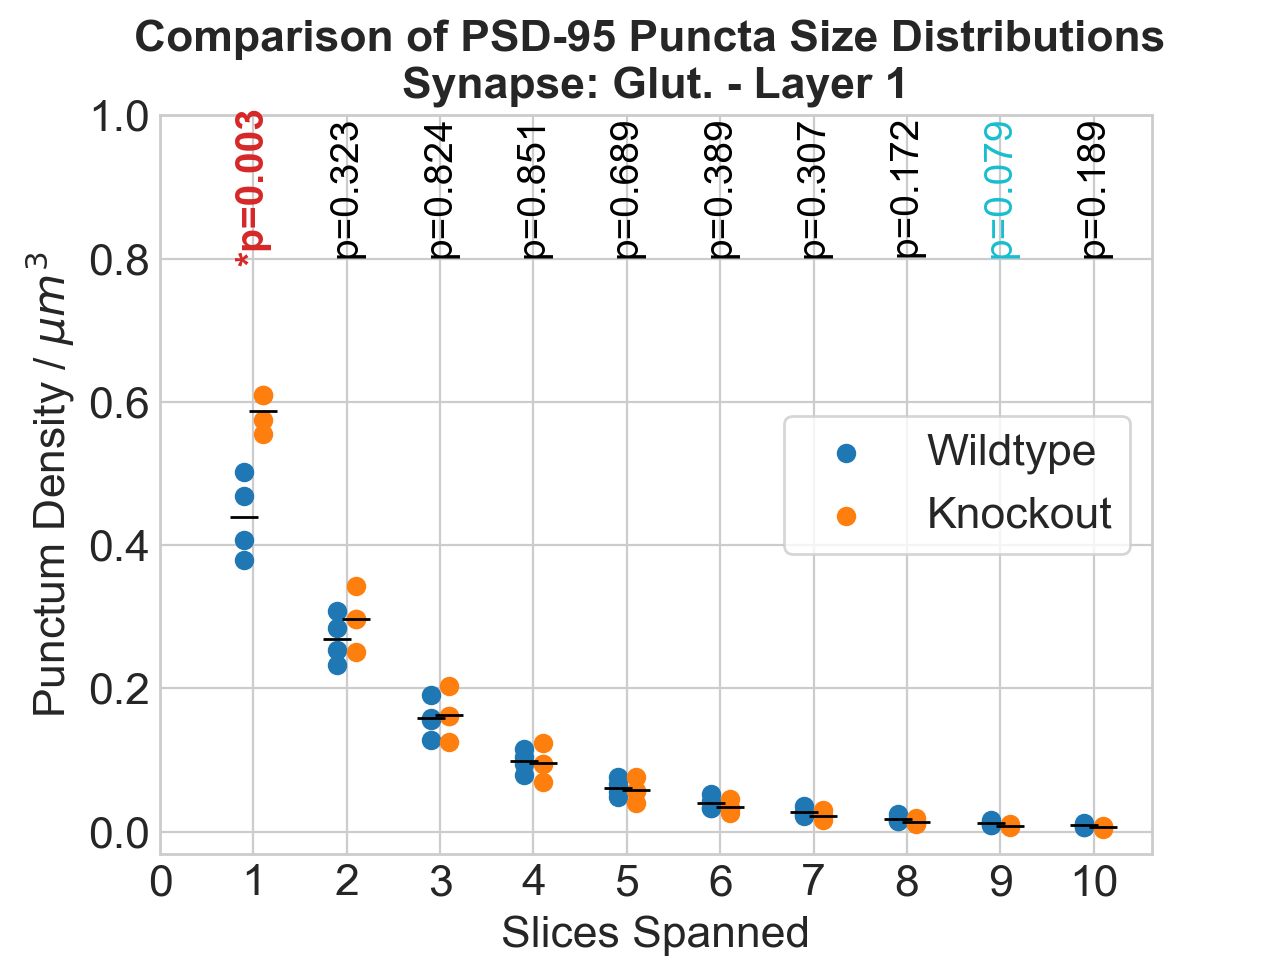

<IPython.core.display.Javascript object>


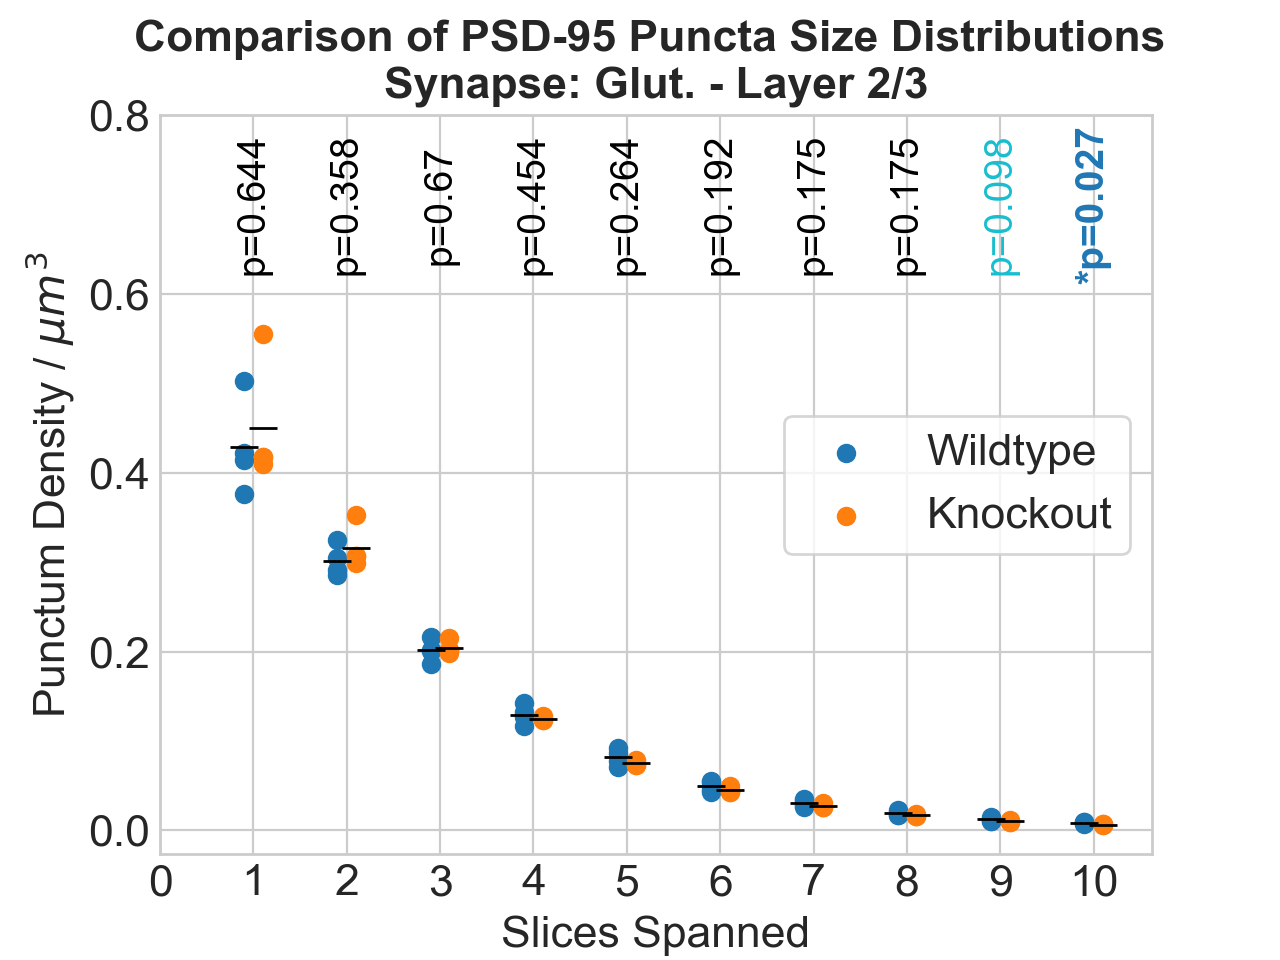

<IPython.core.display.Javascript object>


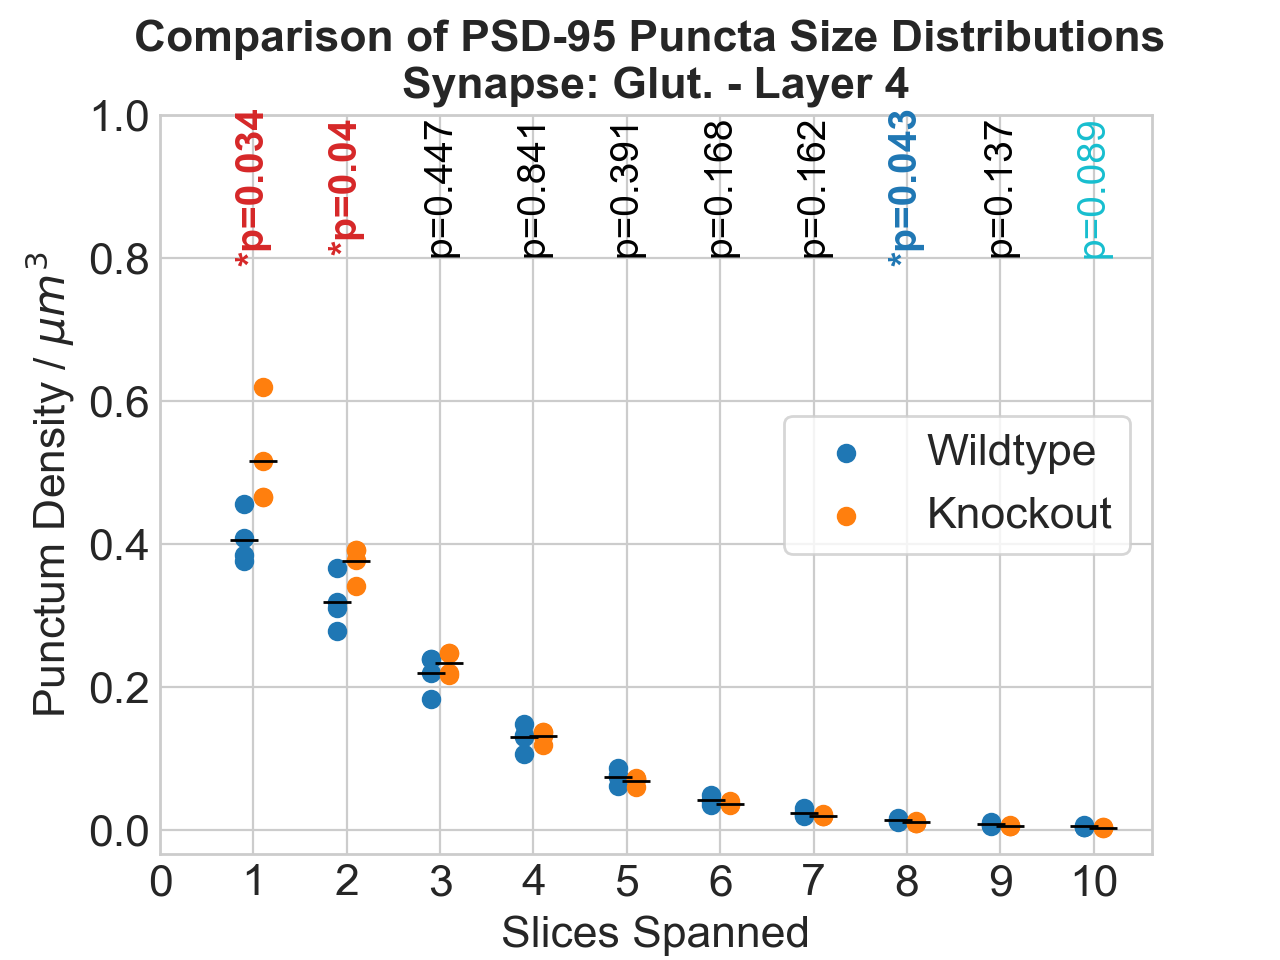

<IPython.core.display.Javascript object>


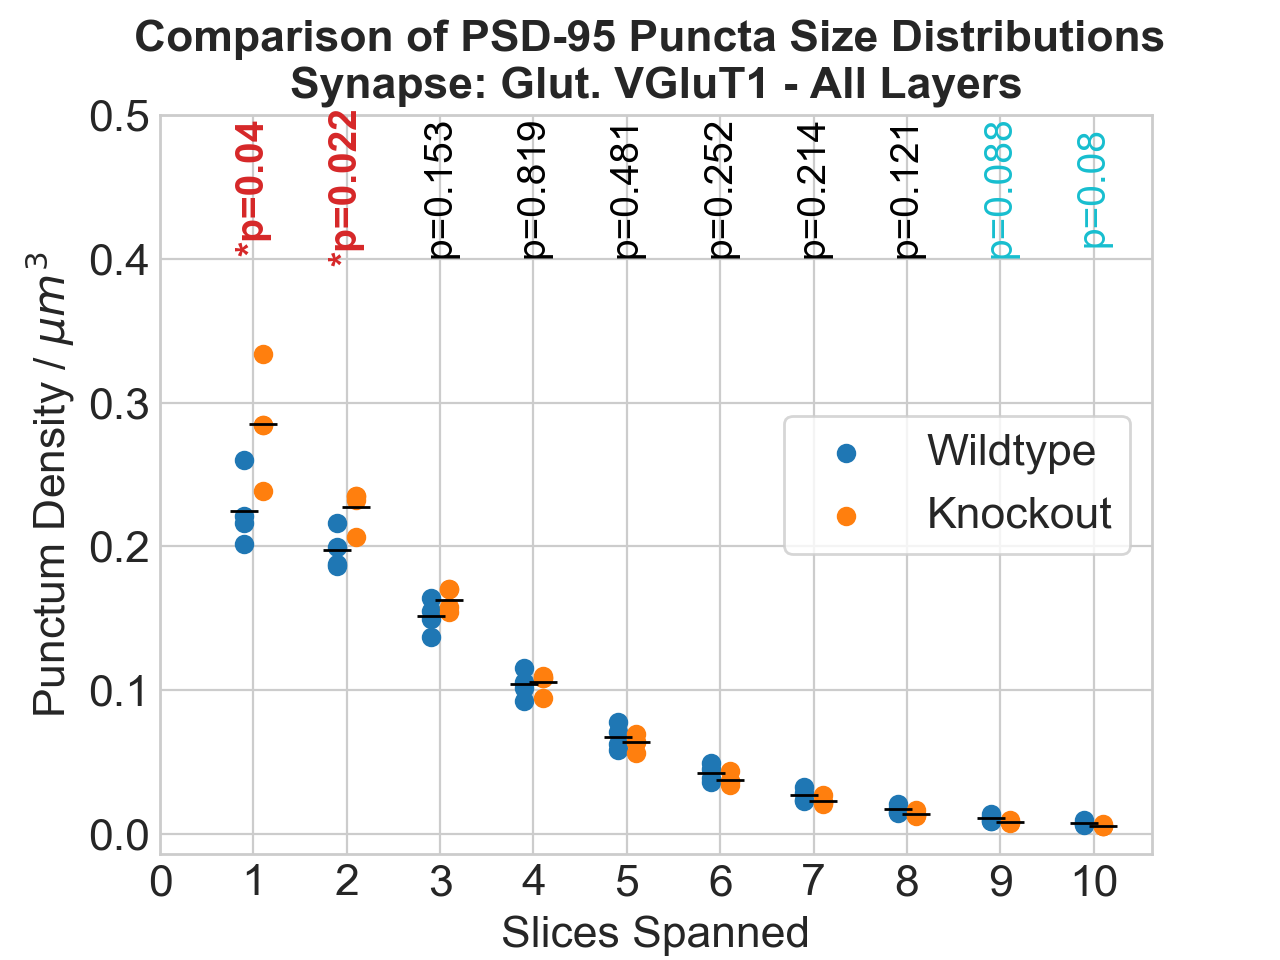

<IPython.core.display.Javascript object>


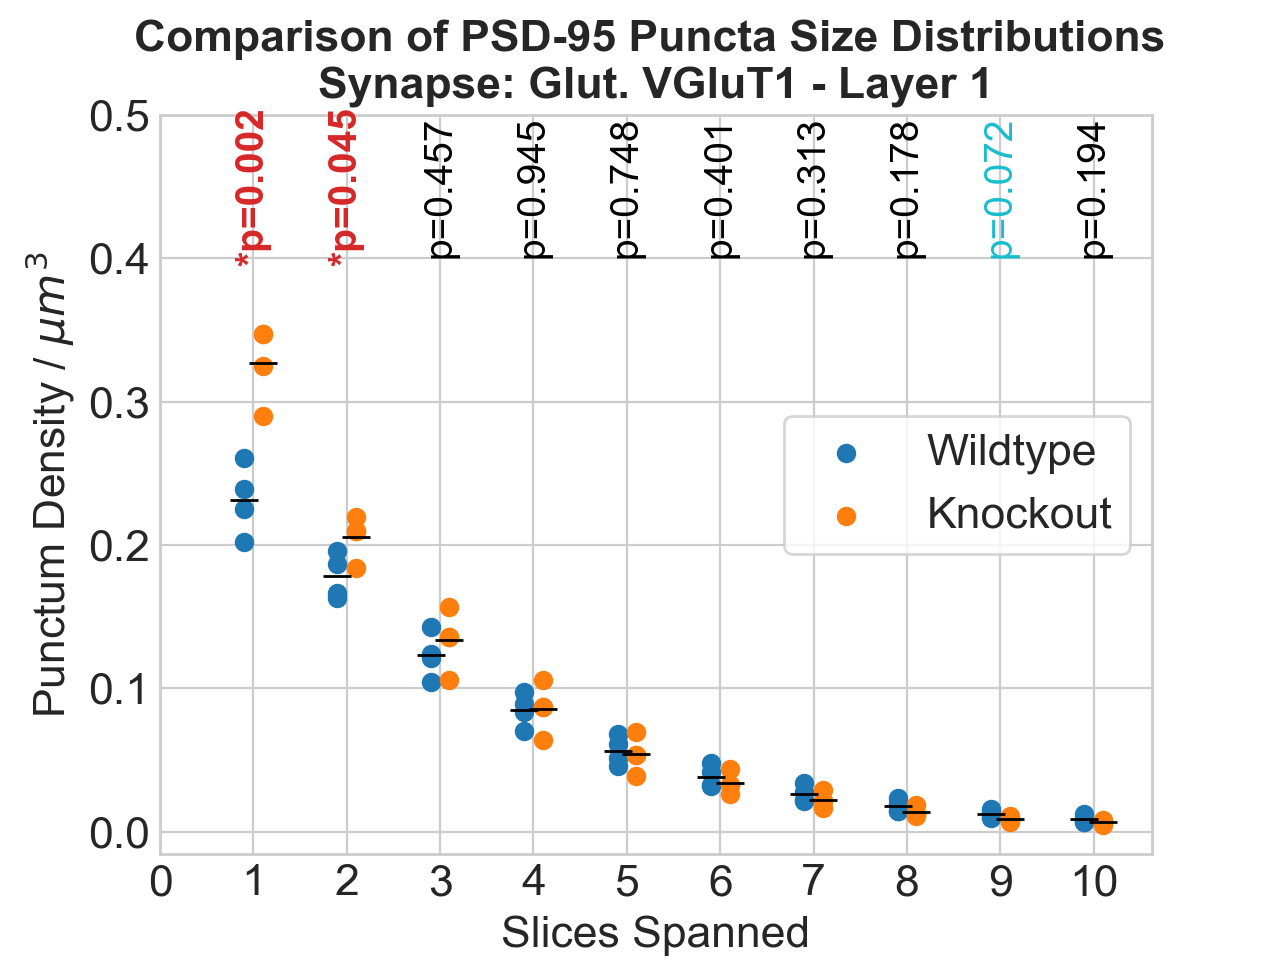

<IPython.core.display.Javascript object>


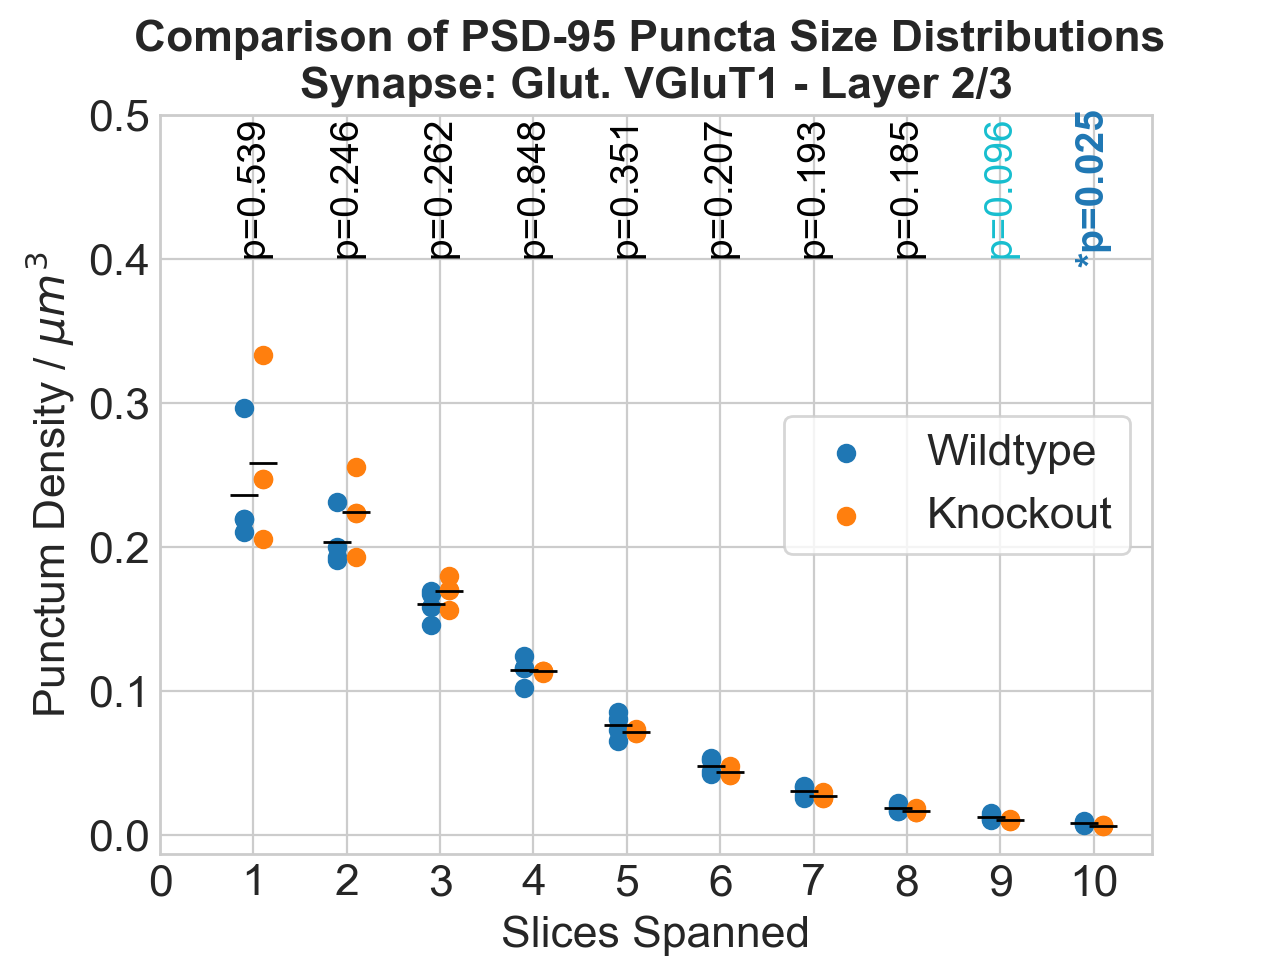

<IPython.core.display.Javascript object>


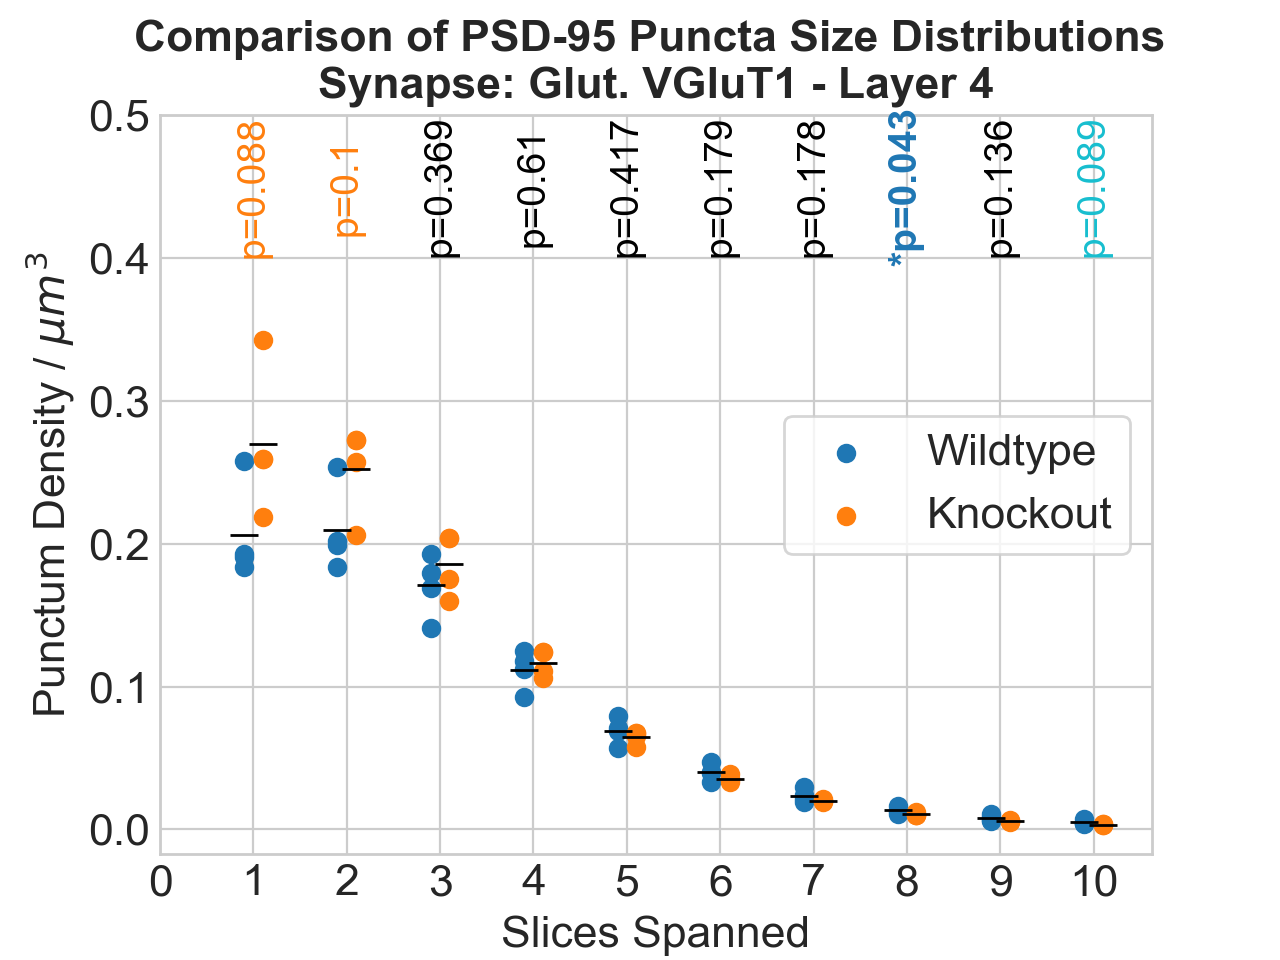

<IPython.core.display.Javascript object>


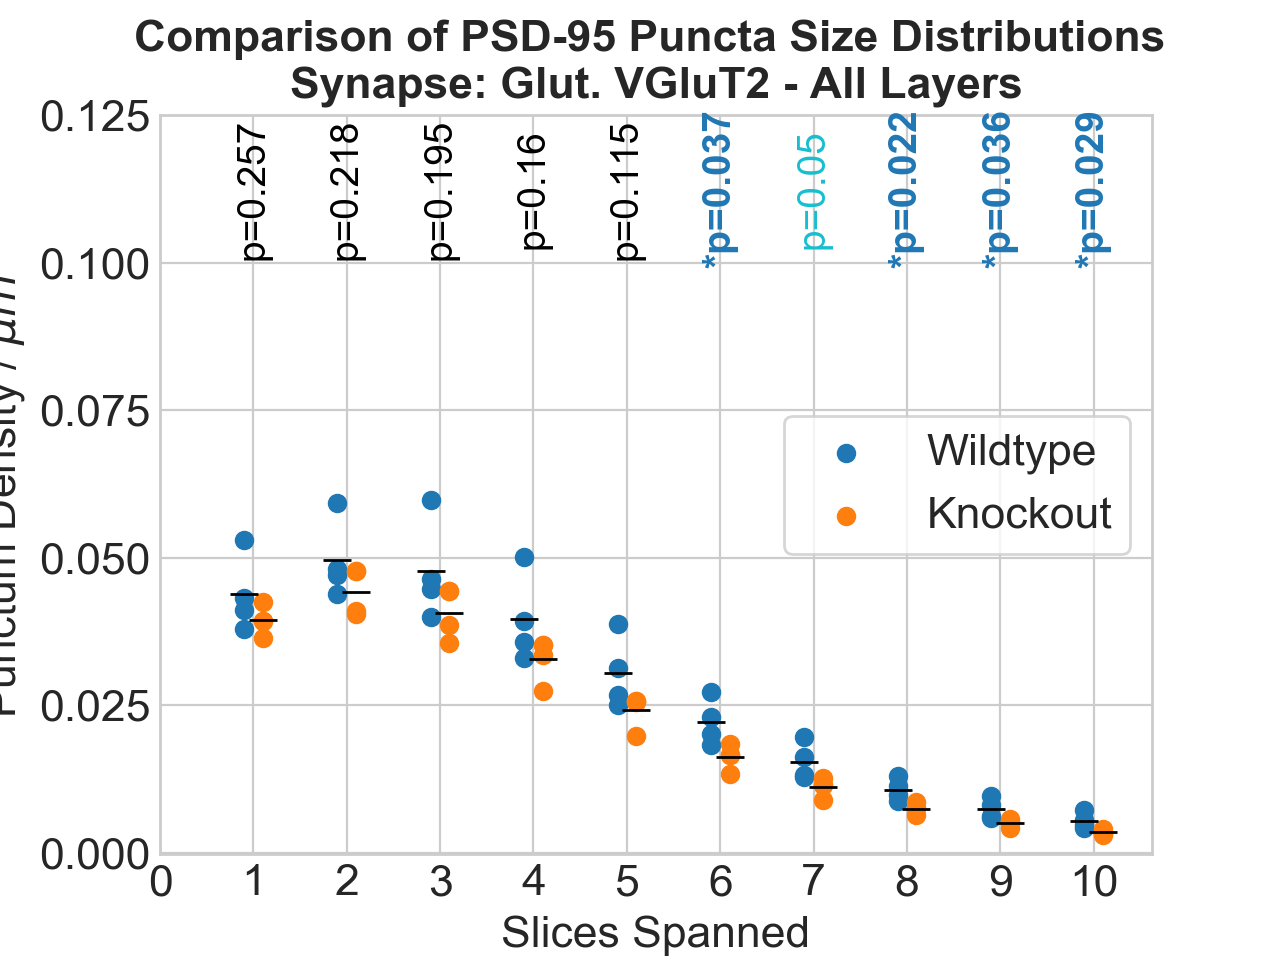

<IPython.core.display.Javascript object>


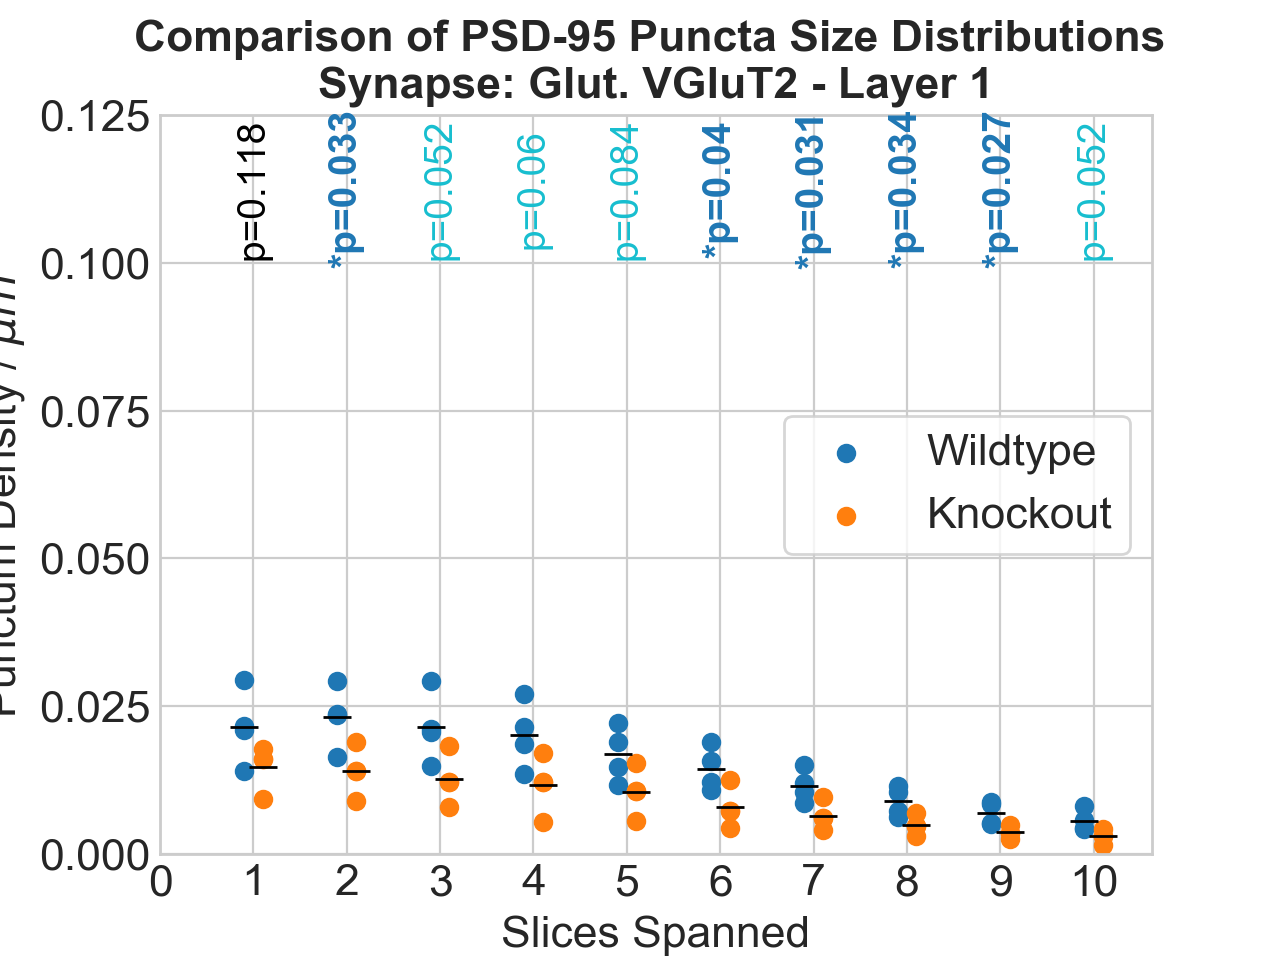

<IPython.core.display.Javascript object>


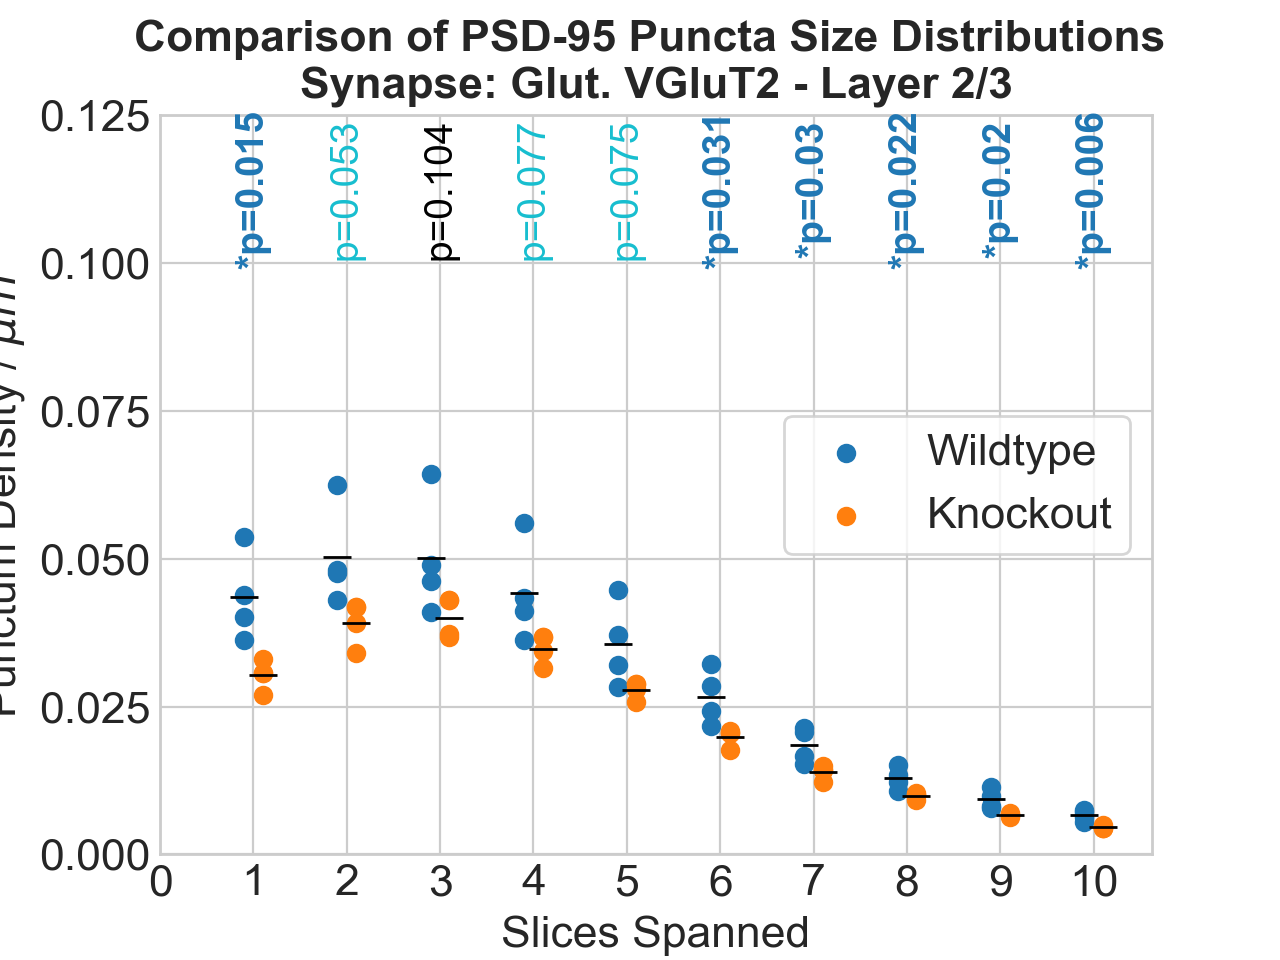

<IPython.core.display.Javascript object>


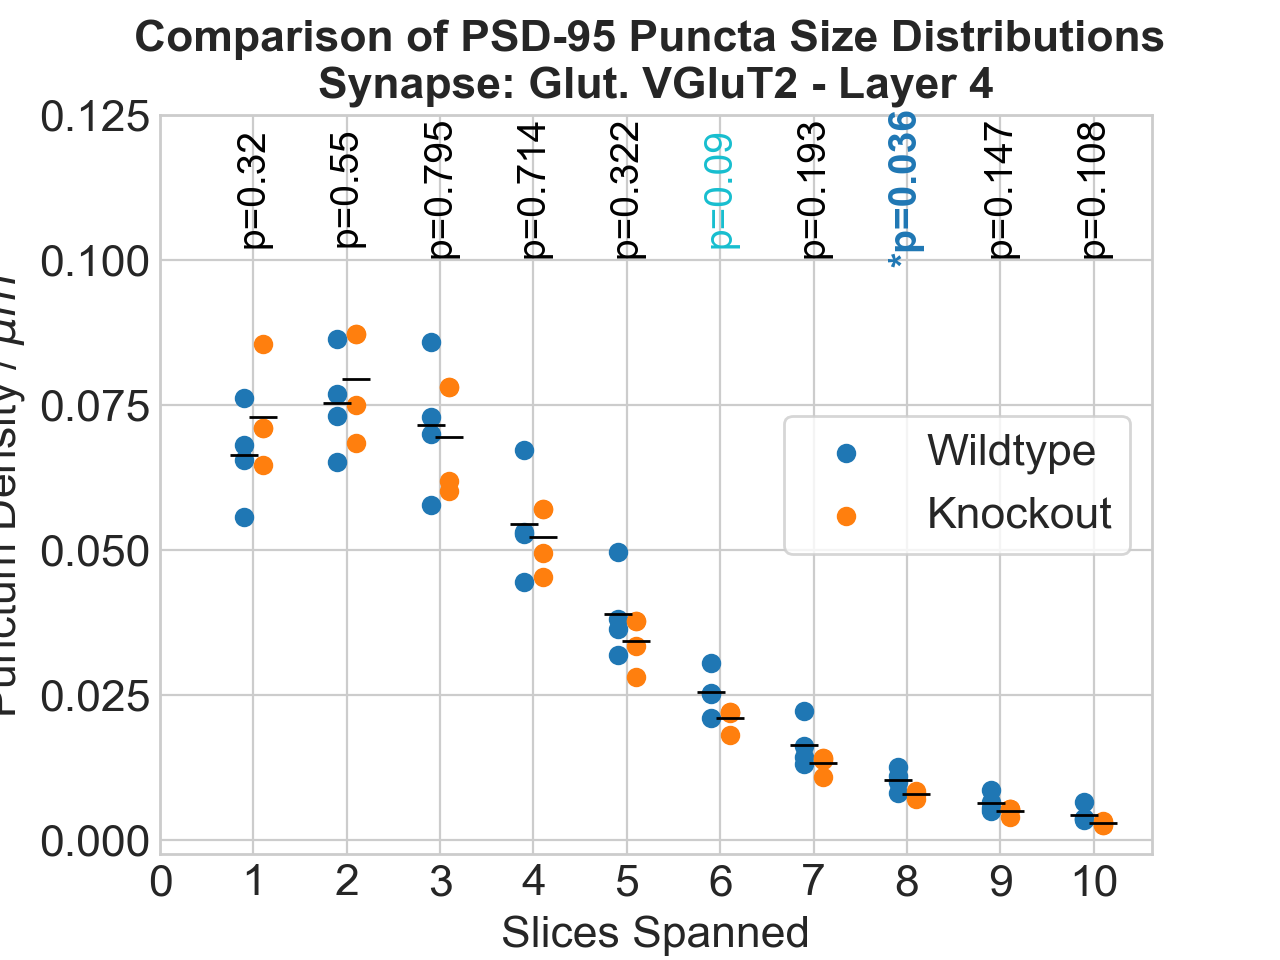

<IPython.core.display.Javascript object>


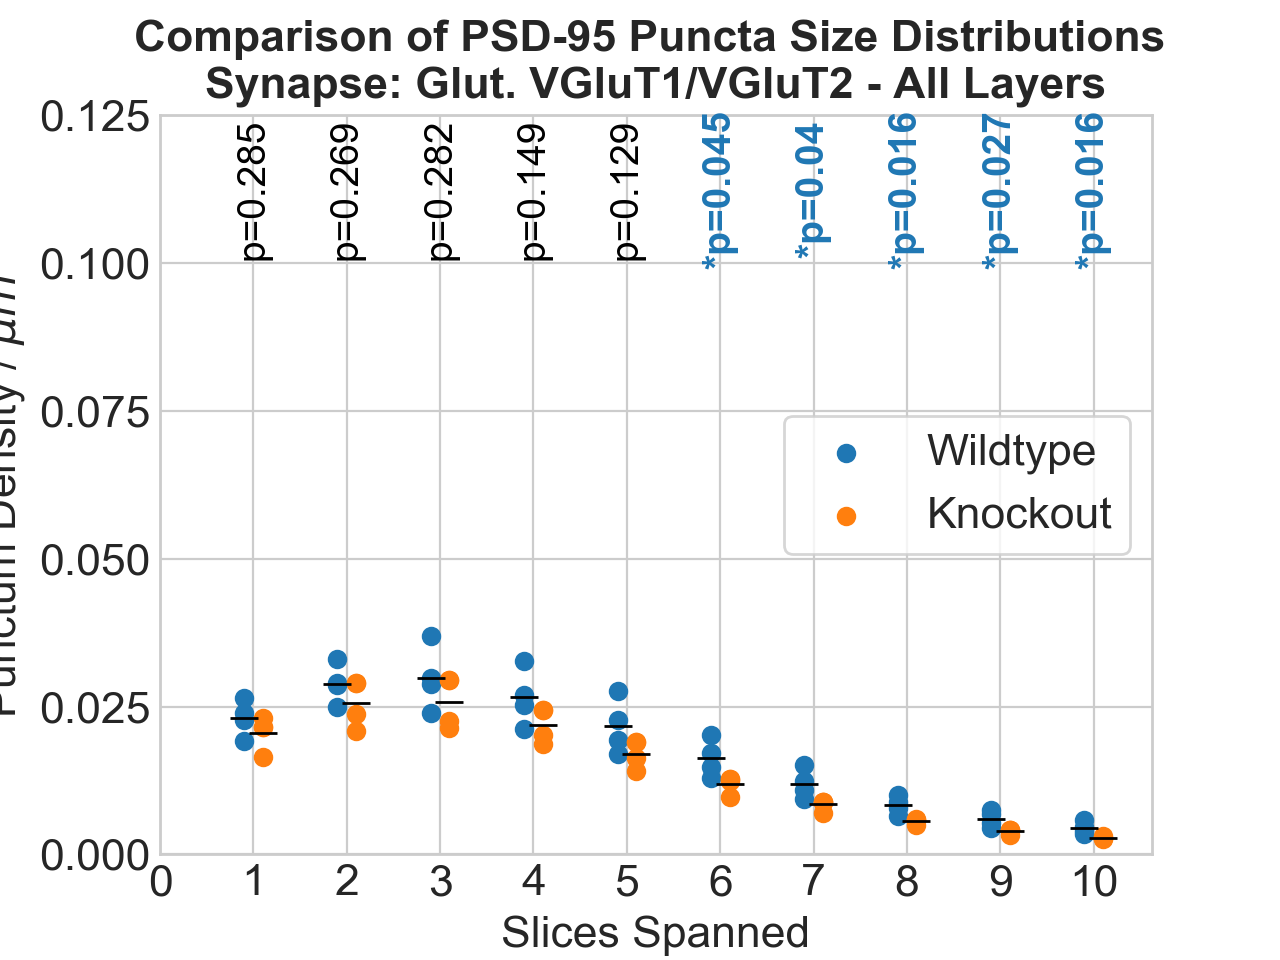

<IPython.core.display.Javascript object>


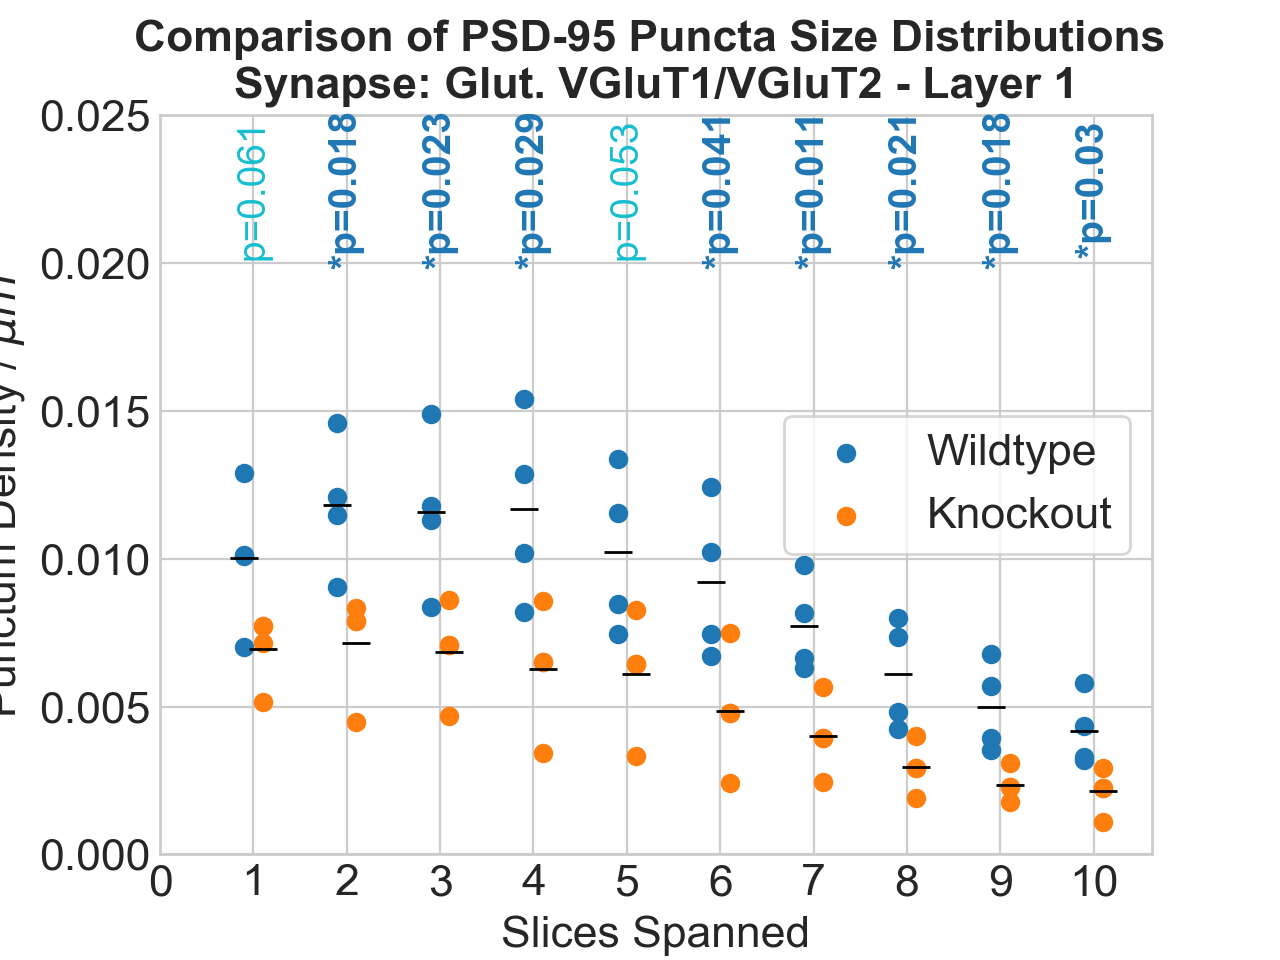

<IPython.core.display.Javascript object>


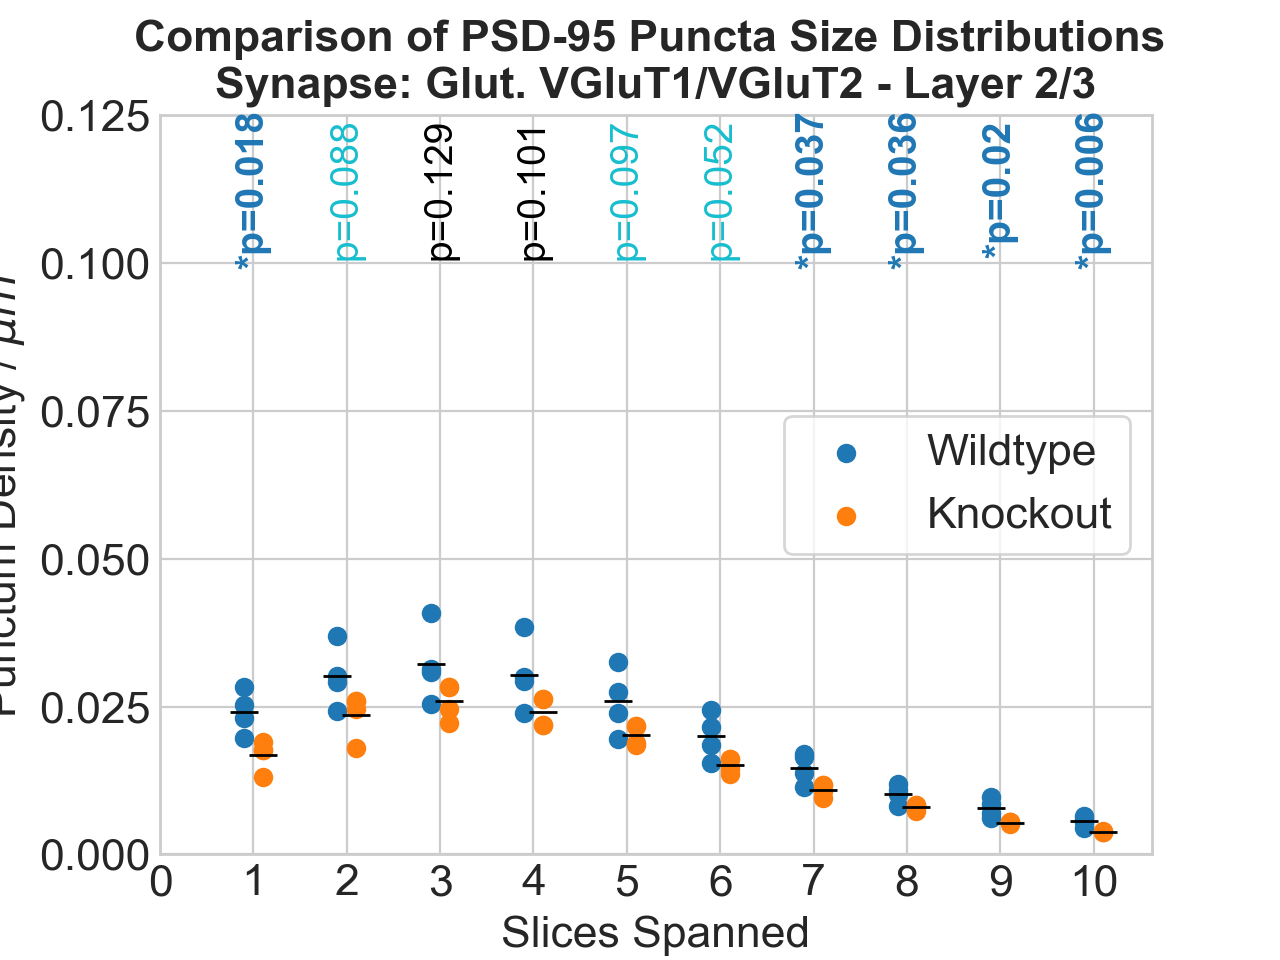

<IPython.core.display.Javascript object>


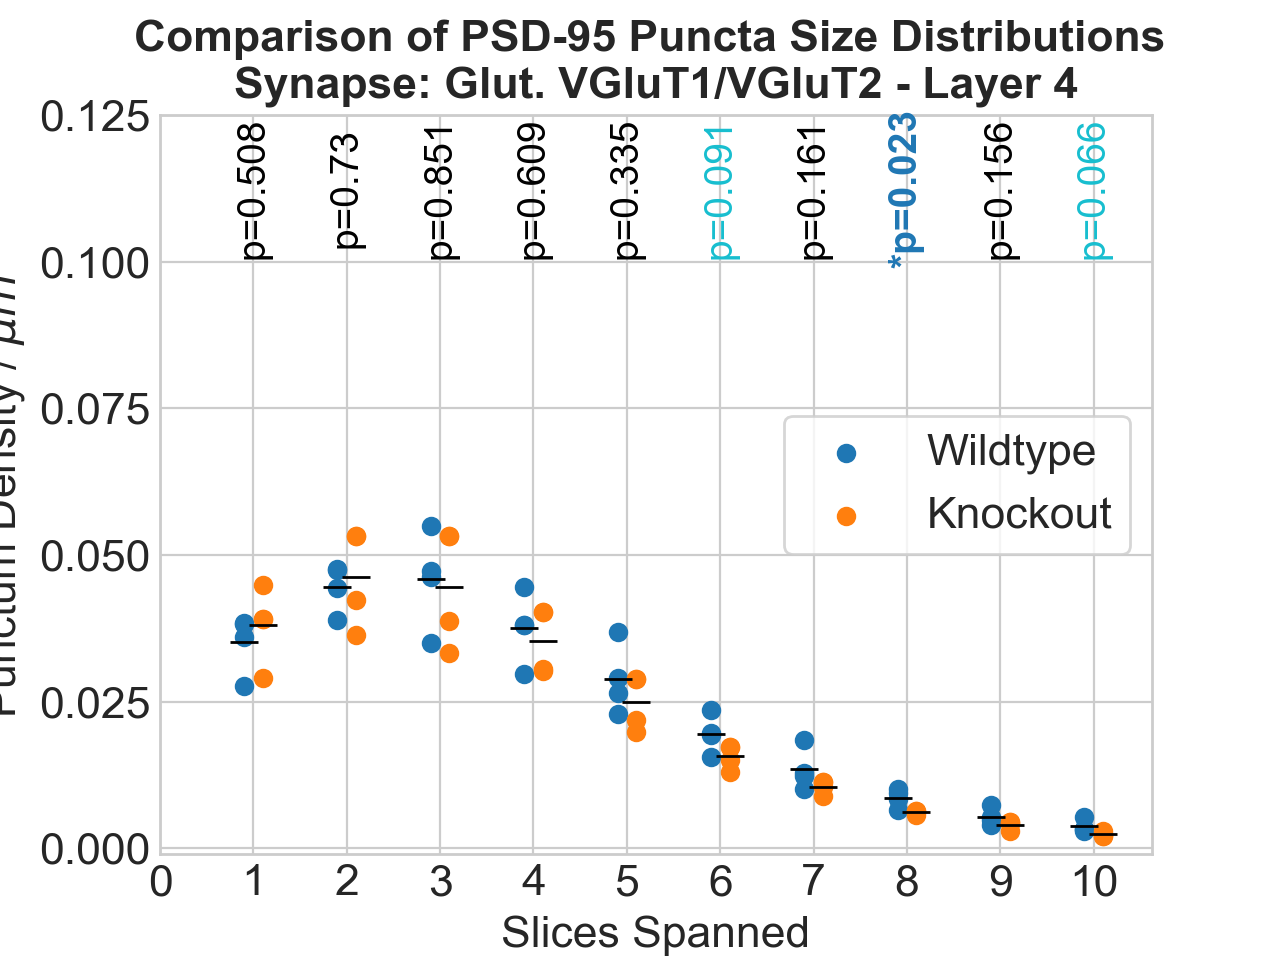

In [11]:
for q in range(0, 4): 
    q_ind = np.mod(q, 4)
    for layer_n, layer_key in enumerate(layer_list): 

        [wt, ko, pval_list] = get_histogram_data(mice_dict, volume_dict, layer_key, q)
        mean_diff_list = [] 
        
        fig = plt.figure()
        plt.style.use('seaborn-whitegrid')
        for x_ind in range(1, 11): 
            xlist = np.ones((4, 1))*x_ind
            offset = 0.1
            plt.plot(x_ind-offset, np.mean(wt, 0)[x_ind], markersize=10, marker = "_", color='black', label='wildtype')
            p0 = plt.scatter(xlist-offset, wt[:, x_ind], color='C0', label='wildtype')

            plt.plot(x_ind+offset, np.mean(ko, 0)[x_ind], markersize=10, marker = "_", color='black', label='knockout')
            p1 = plt.scatter(xlist+offset, ko[:, x_ind], color='C1', label='knockout')
            mean_diff_list.append(np.mean(ko, 0)[x_ind] - np.mean(wt, 0)[x_ind])

        y = np.max([ko, wt])
        [y, yticks] = fxsdata.get_yticks(y)

        for p_n, pval in enumerate(pval_list): 
            pval_str = str(round(pval, 3))
            if pval < 0.05: 
                if (mean_diff_list[p_n] > 0): 
                    plt.text(p_n+1, y, '*p='+pval_str, color='tab:red', fontsize=14, rotation=90,
                         verticalalignment='center', horizontalalignment='center', fontweight='bold')
                elif (mean_diff_list[p_n] < 0):
                    plt.text(p_n+1, y, '*p='+pval_str, color='tab:blue', fontsize=14, rotation=90,
                         verticalalignment='center', horizontalalignment='center', fontweight='bold')

            elif pval < 0.1:
                if (mean_diff_list[p_n] > 0): 
                    plt.text(p_n+1, y, 'p='+pval_str, color='tab:orange', fontsize=14, rotation=90,
                         verticalalignment='center', horizontalalignment='center')
                elif (mean_diff_list[p_n] < 0):
                    plt.text(p_n+1, y, 'p='+pval_str, color='tab:cyan', fontsize=14, rotation=90,
                         verticalalignment='center', horizontalalignment='center')
            else: 
                plt.text(p_n+1, y, 'p='+pval_str, color='black', fontsize=14, rotation=90,
                         verticalalignment='center', horizontalalignment='center')
                
        plt.legend([p0, p1], ['Wildtype', 'Knockout'], frameon=True, loc='center right', fontsize=16)
        plt.ylabel('Punctum Density / $\mu m^3$', fontsize=16)
        plt.xlabel("Slices Spanned", fontsize=16)
        plt.title("Comparison of PSD-95 Puncta Size Distributions \n"+"Synapse: " + synapse_labels[q_ind] + " - " + layer_title_list[layer_n], fontsize=16, fontweight='bold')
        plt.xticks(np.arange(0, 11, step=1), fontsize=16)
        ax = plt.gca()
        plt.yticks(yticks, fontsize=16)

        plt.savefig('figs/psd-histograms/hist_' + 
                    layer_fn_list[layer_n] + '_' + str(q) + '.png',
                    dpi=300, bbox_inches='tight')

        
    

